# PHSX 801 Midterm Review

**Vivan Bhatt**

## Data Preprocessing

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.2 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt

import heapq

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
parton_level_data=np.load('/content/drive/MyDrive/Colab Notebooks/tt_parton14TeV.npy')

data=parton_level_data[:,[16,18,24,25]] #Selecting mbl and met
data_wrong=parton_level_data[:,[20,22,24, 25]]
data_wrong=np.array(data_wrong)
print(data.shape)
print(data_wrong.shape)

(1000000, 4)
(1000000, 4)


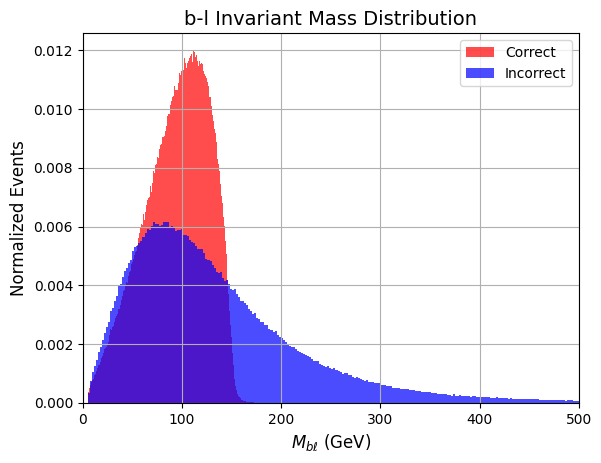

In [4]:
plt.hist(data[:,1], bins='auto', color='r', alpha=0.7, density=True, label = 'Correct')
plt.hist(data_wrong[:,1], bins='auto', color='b', alpha=0.7, density=True, label = 'Incorrect')
plt.xlabel(r'$M_{b\ell}$ (GeV)', fontsize=12)
plt.ylabel('Normalized Events', fontsize=12)
plt.xlim(0, 500)
plt.title('b-l Invariant Mass Distribution', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

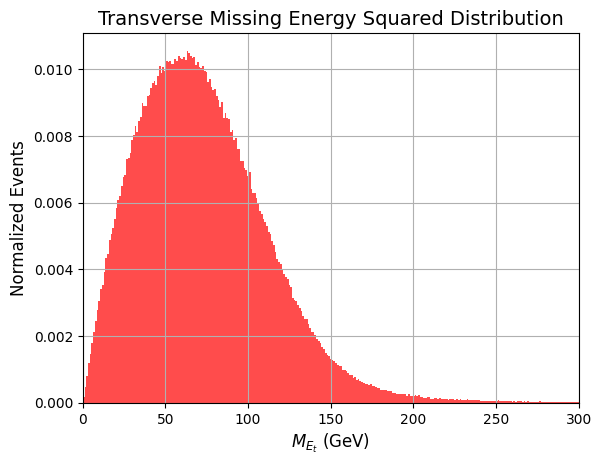

In [5]:
m2_e_t=(data[:,2]**2+data[:,3]**2)**0.5
plt.hist(m2_e_t, bins='auto', color='r', alpha=0.7, density=True)
plt.xlabel(r'$M_{E_t}$ (GeV)', fontsize=12)
plt.ylabel('Normalized Events', fontsize=12)
plt.xlim(0, 300)
plt.title('Transverse Missing Energy Squared Distribution', fontsize=14)
plt.grid(True)

In [6]:
data.shape #Check

(1000000, 4)

In [7]:
mbl11=data[:,0].reshape(data.shape[0],1)
mbl22=data[:,1].reshape(data.shape[0],1)
mbl12=data_wrong[:,0].reshape(data_wrong.shape[0],1)
mbl21=data_wrong[:,1].reshape(data_wrong.shape[0],1)
mbl11.shape

(1000000, 1)

(0.0, 700.0)

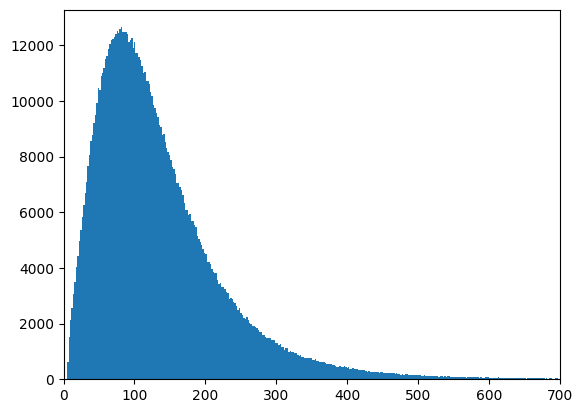

In [8]:
plt.hist(mbl12, bins='auto')
plt.xlim(0,700) #Check to see reasonable range of mbl for rescaling

In [9]:
filt_mbl12=mbl12[mbl12<=700]
filt_mbl12.shape, filt_mbl12.max()

((998324,), tensor(699.90742252, requires_grad=True))

In [10]:
indices = np.where(mbl12 <= 700)[0]
len(indices) #Ignoring all mbl12 greater than 700

998324

In [11]:
filt_mbl21=mbl21[indices]
filt_mbl22=mbl22[indices]
filt_mbl11=mbl11[indices]
filt_mbl21.shape, filt_mbl21.max(), filt_mbl22.max(), filt_mbl11.max() #Selecting corresponding data points from other combinations

((998324, 1),
 tensor(1860.35782507, requires_grad=True),
 tensor(178.87566159, requires_grad=True),
 tensor(180.3203229, requires_grad=True))

In [12]:
scaled_mbl11=filt_mbl11/700
scaled_mbl12=filt_mbl12/700
scaled_mbl22=filt_mbl22/700
scaled_mbl21=filt_mbl21/700
scaled_mbl12.shape, scaled_mbl12.max(), scaled_mbl11.max(), scaled_mbl11.shape, scaled_mbl21.max(), scaled_mbl21.shape #Rescaling everything so as to lie between 0 and 2pi for stable rotations

((998324,),
 tensor(0.99986775, requires_grad=True),
 tensor(0.25760046, requires_grad=True),
 (998324, 1),
 tensor(2.65765404, requires_grad=True),
 (998324, 1))

In [13]:
mbl11=scaled_mbl11.reshape(scaled_mbl11.shape[0],1)
mbl12=scaled_mbl12.reshape(scaled_mbl12.shape[0],1)
mbl21=scaled_mbl21.reshape(scaled_mbl21.shape[0],1)
mbl22=scaled_mbl22.reshape(scaled_mbl22.shape[0],1)
mbl12.shape, mbl12.max(), mbl11.max(), mbl11.shape, mbl21.max(), mbl21.shape


((998324, 1),
 tensor(0.99986775, requires_grad=True),
 tensor(0.25760046, requires_grad=True),
 (998324, 1),
 tensor(2.65765404, requires_grad=True),
 (998324, 1))

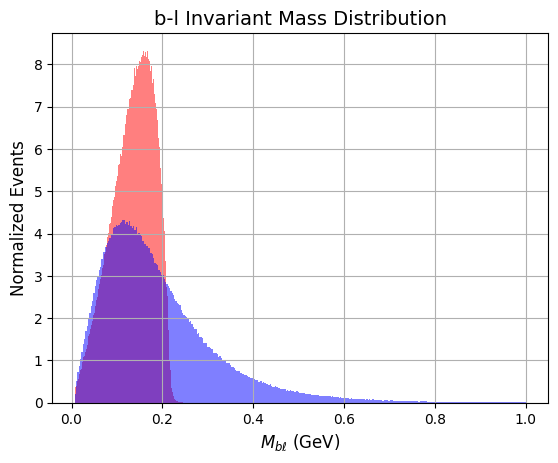

In [14]:
plt.hist(mbl11, color='r', bins='auto',alpha=0.5, density=True)
plt.hist(mbl12, color='b', bins='auto', alpha=0.5, density=True)
plt.xlabel(r'$M_{b\ell}$ (GeV)', fontsize=12)
plt.ylabel('Normalized Events', fontsize=12)
plt.title('b-l Invariant Mass Distribution', fontsize=14)
plt.grid(True)

In [15]:
data=np.concatenate((mbl11,mbl22, np.zeros((mbl11.shape[0],1))),axis=1) #Padding with zeroes since we have two input features/rotation angles but gates need three
data_wrong=np.concatenate((mbl12,mbl21, np.zeros((mbl11.shape[0],1))),axis=1)

print(data.shape, data_wrong.shape)

(998324, 3) (998324, 3)


In [16]:
label=np.ones(data.shape[0])
label_wrong=np.zeros(data_wrong.shape[0])

In [17]:
x_train, y_train = np.concatenate((data[:900000], data_wrong[:900000])),np.concatenate((label[:900000], label_wrong[:900000]))
x_test, y_test = np.concatenate((data[900000:], data_wrong[900000:])),np.concatenate((label[900000:], label_wrong[900000:]))
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1800000, 3), (1800000,), (196648, 3), (196648,))

In [18]:
idx = np.arange(x_train.shape[0])
np.random.shuffle(idx)
x_train,y_train = x_train[idx], y_train[idx]

idx2 = np.arange(x_test.shape[0])
np.random.shuffle(idx2)
x_test,y_test = x_test[idx2], y_test[idx2]

x_train.shape, y_train.shape, x_test.shape, y_test.shape #Random shuffling of correct and incorrect combinations

((1800000, 3), (1800000,), (196648, 3), (196648,))

## Deep Neural Network

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.utils import to_categorical # np_utils has been replaced with to_categorical

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [20]:
model = Sequential()

model.add(Dense(units=128, input_shape=(3, ), activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
#model.add(Dense(units=128, activation="relu"))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(units=128, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dense(units=128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="sigmoid"))

adam = optimizers.Adam(learning_rate=0.001)

model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,177 (71.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
mcp_save = ModelCheckpoint('dnn_temp.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', verbose=1, patience=40)

In [22]:
BATCH_SIZE = 1024
epochs = 100
history = model.fit(x=x_train, y=y_train, batch_size = BATCH_SIZE, epochs = epochs, callbacks=[mcp_save, es], validation_split=0.1 )

Epoch 1/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7529 - loss: 0.6903 - val_accuracy: 0.7641 - val_loss: 0.4645
Epoch 2/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7640 - loss: 0.4627 - val_accuracy: 0.7682 - val_loss: 0.4560
Epoch 3/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7651 - loss: 0.4605 - val_accuracy: 0.7700 - val_loss: 0.4550
Epoch 4/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.7661 - loss: 0.4598 - val_accuracy: 0.7672 - val_loss: 0.4536
Epoch 5/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7659 - loss: 0.4596 - val_accuracy: 0.7689 - val_loss: 0.4531
Epoch 6/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7672 - loss: 0.4570 - val_accuracy: 0.7697 - val_loss: 0.4548
Epoch 7/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7662 - loss: 0.4581 - val_accuracy: 0.7686 - val_loss: 0.4580
Epoch 8/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 

In [23]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print results
print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step - accuracy: 0.7691 - loss: 0.4507
6146/6146 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7702 - loss: 0.4494
Train Loss: 0.4509150981903076, Train Accuracy: 0.7691866755485535
Test Loss: 0.450149267911911, Test Accuracy: 0.7695018649101257


In [24]:
# Predict labels on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) # pick the highest probability with "np.argmax()", and turn it into an index uing "axis=1"

# print vector of probabilities
print(f"What Softmax predicted: {y_pred}")

# print predicted number
print(f"What Softmax actually means: {y_pred_classes}")

6146/6146 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
What Softmax predicted: [[0.76497287]
 [0.5541394 ]
 [0.76044285]
 ...
 [0.79793644]
 [0.662759  ]
 [0.61946535]]
What Softmax actually means: [0 0 0 ... 0 0 0]


In [25]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [26]:
random_num = np.random.choice(len(x_test))
x_sample = x_test[random_num]

# save true label of this sample in a variable
y_true = np.argmax(y_test)
#y_sample_true = y_true[random_num]

# save a predicted label of this sample in a variable
y_sample_pred_class = y_pred_classes[random_num]

In [27]:
#roc

y_test_bin = label_binarize(y_test, classes=[0,1])  # Shape: (num_samples, num_classes)

def compute_roc_curve(y_true, y_scores):
    # y_true: One-hot encoded ground truth labels (shape: (num_samples, num_classes))
    # y_scores: Predicted probabilities (shape: (num_samples, num_classes))

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return fpr, tpr, thresholds

fpr, tpr, thresholds = compute_roc_curve(y_test_bin, y_pred)

<ipython-input-28-4093e6d5dbdc>:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr, tpr, label=f'(AUC = {np.trapz(tpr, fpr):.2f})')


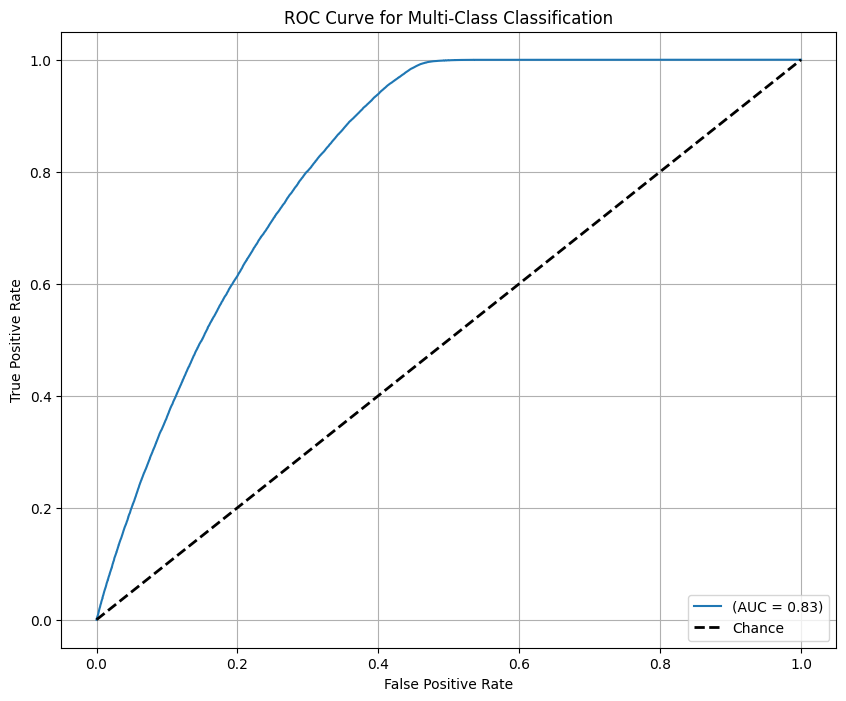

In [28]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class

plt.plot(fpr, tpr, label=f'(AUC = {np.trapz(tpr, fpr):.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Chance', linewidth=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)

# Show plot
plt.show()

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

6146/6146 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7702 - loss: 0.4494
Test Loss: 0.450149267911911, Test Accuracy: 0.7695018649101257


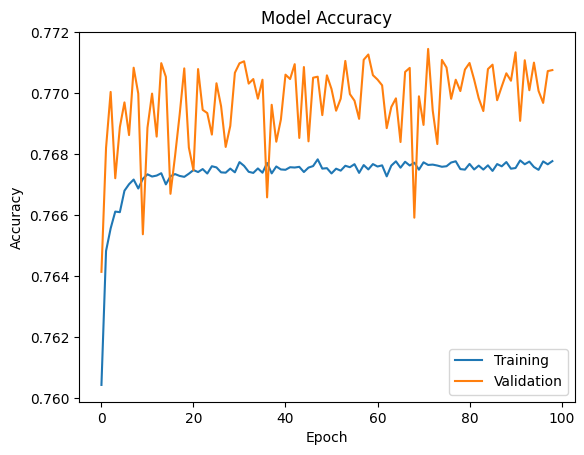

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

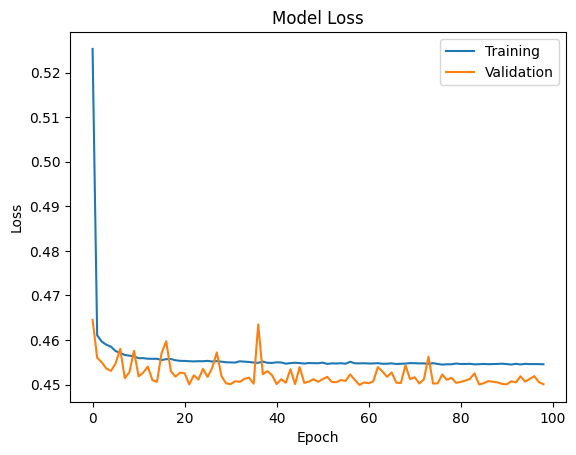

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.show()

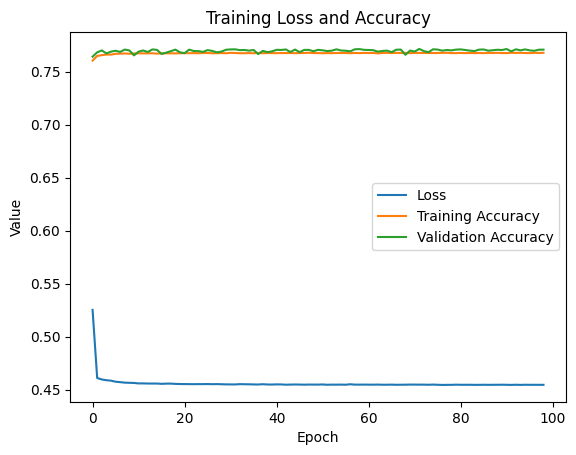

In [52]:
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

In [32]:
y_pred = model.predict(x_test)
print('Test loss:', y_pred[0])
print('Test accuracy:', y_pred[1])
y_pred.shape

6146/6146 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Test loss: [0.76497287]
Test accuracy: [0.5541394]


(196648, 1)

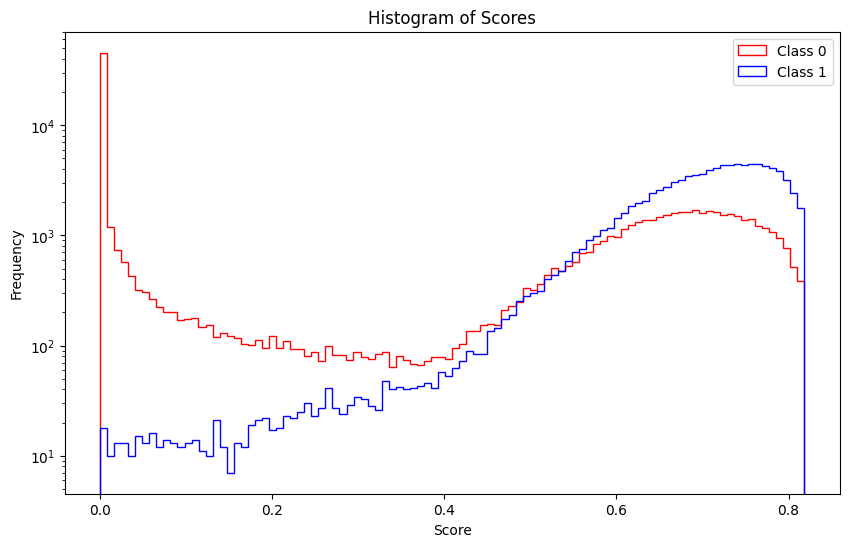

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred[y_test ==0], bins=100,color='r',histtype='step')
plt.hist(y_pred[y_test ==1], bins=100,color='b',histtype='step')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.yscale('log')
plt.legend(['Class 0', 'Class 1'])
plt.show()

## Data Reuploading

In [34]:
x_train=x_train[:2000,:]
y_train=y_train[:2000]
x_test=x_test[:2000,:]
y_test=y_test[:2000]

x_train.shape, y_train.shape, x_test.shape, y_test.shape #Selecting 2000 data points for training and testing

((2000, 3), (2000,), (2000, 3), (2000,))

In [35]:
from pennylane import numpy as np
import pennylane as qml

def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

In [36]:
print(state_labels[0], '&', state_labels[1])

[[1]
 [0]] & [[0]
 [1]]


In [37]:
print(density_matrix(state_labels[0]), '&', density_matrix(state_labels[1]))

[[1 0]
 [0 0]] & [[0 0]
 [0 1]]


In [38]:
dev = qml.device("lightning.qubit",wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    qml.Hadamard(wires=0)

    rot_angles = x[:3]

    for p in params:
        qml.Rot(*rot_angles, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))

In [40]:
def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        # Convert y[i] to a Python integer if it's a PennyLane tensor,
        # a NumPy array, an ArrayBox, or similar object.
        if isinstance(y[i], (qml.numpy.ndarray, np.ndarray,type(qml.numpy.tensor(0)))):
            label_index = int(y[i].item()) if y[i].size == 1 else int(y[i])
        # Check if it's an ArrayBox-like object or has a similar structure
        elif hasattr(y[i], '_value'):
            label_index = int(y[i]._value)
        # Check if it's a tensor-like object with a 'numpy' method
        elif hasattr(y[i], 'numpy') and callable(y[i].numpy):
            label_index = int(y[i].numpy())
        else:
            label_index = int(y[i])  # Assume y[i] is already an integer

        f = qcircuit(params, x[i], dm_labels[label_index])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [41]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [42]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 10
learning_rate = 0.1
epochs = 20
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

In [43]:
predicted_train, fidel_train = test(params, x_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, x_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, x_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.314579 | Train accuracy: 0.538000 | Test Accuracy: 0.527500


In [44]:
loss_history = []
accuracy_train_history = []
accuracy_test_history = []

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(x_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, x_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, x_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, x_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)

    loss_history.append(loss)
    accuracy_train_history.append(accuracy_train)
    accuracy_test_history.append(accuracy_test)

    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  1 | Loss: 0.204029 | Train accuracy: 0.717500 | Test accuracy: 0.706000
Epoch:  2 | Loss: 0.203786 | Train accuracy: 0.724000 | Test accuracy: 0.710500
Epoch:  3 | Loss: 0.208473 | Train accuracy: 0.625000 | Test accuracy: 0.613500
Epoch:  4 | Loss: 0.202061 | Train accuracy: 0.722000 | Test accuracy: 0.695500
Epoch:  5 | Loss: 0.214301 | Train accuracy: 0.581000 | Test accuracy: 0.606500
Epoch:  6 | Loss: 0.205796 | Train accuracy: 0.729000 | Test accuracy: 0.714000
Epoch:  7 | Loss: 0.218393 | Train accuracy: 0.694500 | Test accuracy: 0.693500
Epoch:  8 | Loss: 0.205194 | Train accuracy: 0.693000 | Test accuracy: 0.686500
Epoch:  9 | Loss: 0.206400 | Train accuracy: 0.641500 | Test accuracy: 0.650000
Epoch: 10 | Loss: 0.205165 | Train accuracy: 0.682000 | Test accuracy: 0.668500
Epoch: 11 | Loss: 0.208202 | Train accuracy: 0.700500 | Test accuracy: 0.683000
Epoch: 12 | Loss: 0.204490 | Train accuracy: 0.726000 | Test accuracy: 0.710500
Epoch: 13 | Loss: 0.209001 | Train accur

In [45]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

Cost: 0.200590 | Train accuracy 0.704500 | Test Accuracy : 0.686500
Learned weights
Layer 0: [ 0.82706699 -0.95816807  0.17973628]
Layer 1: [ 0.1642749   0.34994294 -0.67762483]
Layer 2: [-0.53136003  1.03118252  0.01586802]
Layer 3: [ 2.16181887 -0.73605365  2.09158434]
Layer 4: [ 0.66362943 -0.17954964 -0.07726573]
Layer 5: [-0.37972851 -0.29103611  0.47154972]
Layer 6: [ 0.79783045  1.34324545 -0.32108465]
Layer 7: [1.81702306 0.40677282 2.80404559]
Layer 8: [ 0.48479201 -0.15273922  0.98301568]
Layer 9: [2.07968966 0.04074517 0.26778099]


(46,) (1954,)
(744,) (1256,)
(991,) (1009,)


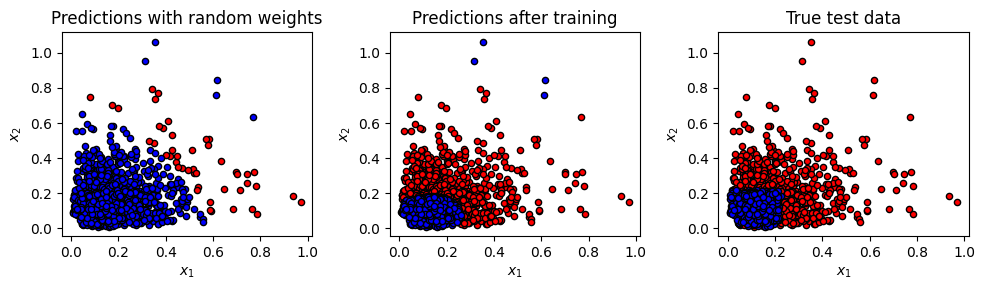

In [46]:
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    print(x[reds, 0].shape, x[blues, 0].shape)
    #return fig, ax

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(x_test, initial_predictions, fig, axes[0])
plot_data(x_test, predicted_test, fig, axes[1])
plot_data(x_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

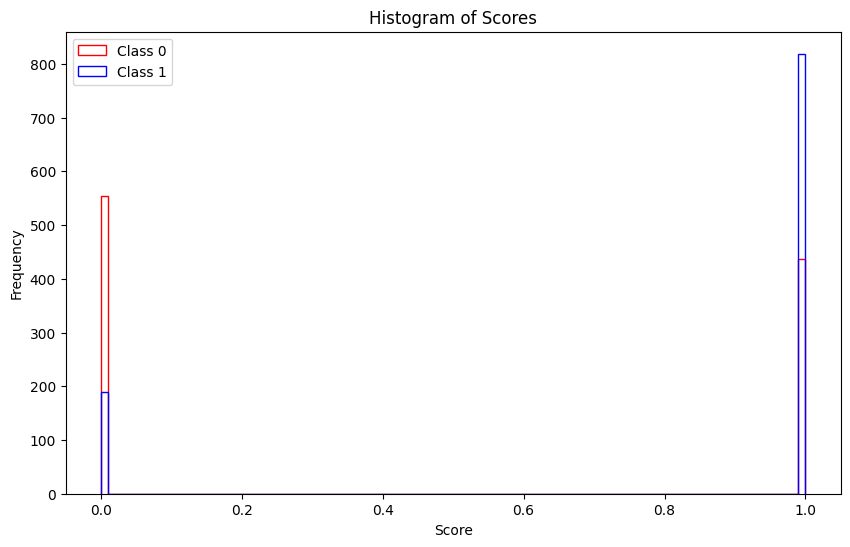

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(predicted_test[y_test ==0], bins=100,color='r',histtype='step')
plt.hist(predicted_test[y_test ==1], bins=100,color='b',histtype='step')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
#plt.yscale('log')
plt.legend(['Class 0', 'Class 1'])
plt.show()

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predicted_test)
roc_auc = auc(fpr, tpr)

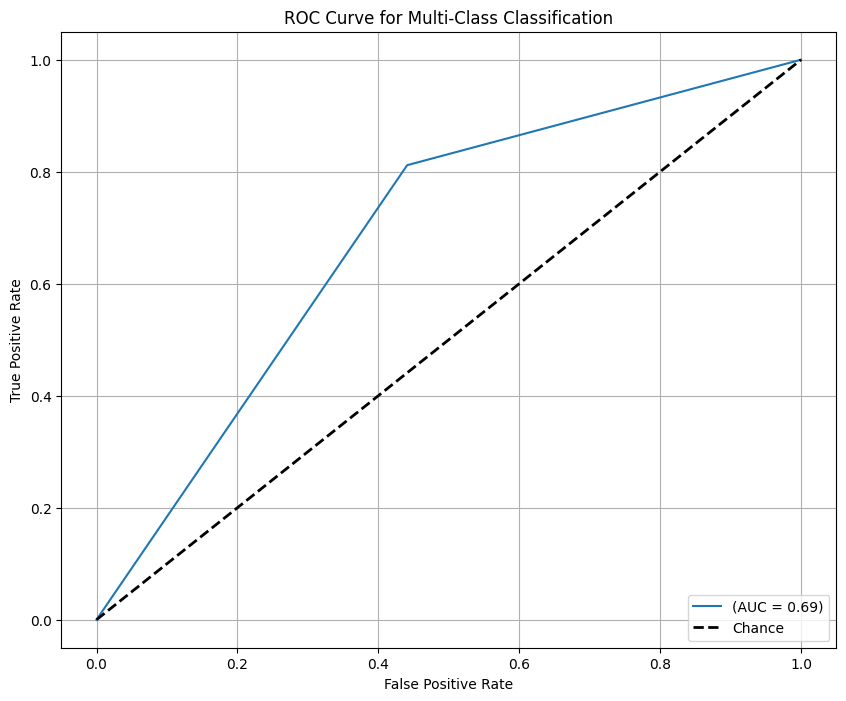

In [49]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class

plt.plot(fpr, tpr, label=f'(AUC = {np.trapz(tpr, fpr):.2f})')

# Plot diagonal (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Chance', linewidth=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid(True)

# Show plot
plt.show()

Testing Loss = 0.20268790947683807


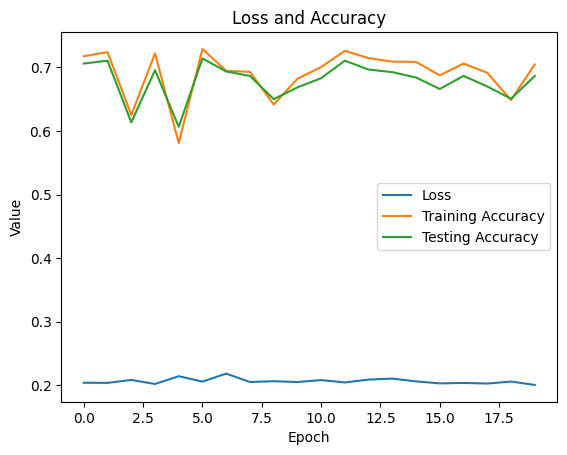

In [65]:
plt.figure()
plt.plot(range(epochs), loss_history, label='Loss')
plt.plot(range(epochs), accuracy_train_history, label='Training Accuracy')
plt.plot(range(epochs), accuracy_test_history, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Loss and Accuracy')
plt.legend()
print(f"Testing Loss = {cost(params, x_test, y_test, state_labels)}")
plt.show()
